In [65]:
!pip install pycountry

# Data Aggregation

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.graph_objects as go

Michael: I loaded the vaccination data from Our World in Data. The WHO one only included member countries, but the OWID one is more complete. OWID also has cases data in their [repo](https://github.com/owid/covid-19-data/tree/master/public/data) so we can pull those as well.

Here's a description of vaccine data
![](https://drive.google.com/uc?export=view&id=1C86XuYC1wXrI0-cVjZAUhfywUiH_Dcfo)

In [67]:
vax_raw = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv")

# list of countries with continents I found online
countries = pd.read_csv("https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv")


# process data
# the vax data does not have continent information, so I had to add it
# the data also has aggregated data for africa itself (as well as other continents or groups like the EU)
countries = countries[["alpha-3", "region"]]
africa_row = ["OWID_AFR", "Africa"]
countries.loc[len(countries)] = africa_row # add country code for Africa
vax = vax_raw.merge(right=countries, left_on="iso_code", right_on="alpha-3") # add continent info for vax data
vax["date"] = pd.to_datetime(vax["date"])

# get only africa data, should be 54 countries + 1 aggregated
africa_vax = vax[vax["region"] == "Africa"]
len(africa_vax["iso_code"].unique())


55

In [68]:
# make a chart for country-code correspondence
countries = africa_vax[["location", "iso_code"]].groupby("location").head(1)
new_countries = ['Cabo Verde', 'Congo (Brazzaville)', "Côte d'Ivoire", "Congo (Democratic Republic)", "eSwatini", "São Tomé and Príncipe"]
new_codes = ["CPV", "COG", "CIV", "COD", "SWZ", "STP"]
df_new_countries = pd.DataFrame({"location": new_countries, "iso_code":new_codes})
countries = countries.append(df_new_countries).reset_index().iloc[:,1:]
countries

,location,iso_code
0,Africa,OWID_AFR
1,Algeria,DZA
2,Angola,AGO
3,Benin,BEN
4,Botswana,BWA
...,...,...
56,Congo (Brazzaville),COG
57,Côte d'Ivoire,CIV
58,Congo (Democratic Republic),COD
59,eSwatini,SWZ


In [69]:
# plotting percentage of people vaccinated
# you can filter the dataframe to get just a country
fig = px.line(africa_vax, x="date", y="people_vaccinated_per_hundred", color='location')
#fig.show()

To get a sense of what we are dealing with, I ran a quick regression using a negative-binomial link (as we have count data here) on the overall vaccination numbers for Africa. The result is ridiculous btw :(

In [70]:
start_date = min(africa_vax["date"]) # encode this date (2021/1/9) as day 0
africa_vax.loc[:,"day"] = africa_vax["date"].sub(pd.Timestamp(start_date)).dt.days # convert date to day number
overall_africa_vax = africa_vax[africa_vax["location"] == "Africa"] # pull out only africa data

results = smf.glm('people_fully_vaccinated ~ day', data=overall_africa_vax, family=sm.families.NegativeBinomial()).fit()


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [71]:
#results.summary()

In [72]:
# present prediction results
new_data = pd.DataFrame({"day": np.arange(453,654)}) # predict for the next 200 days
prediction = results.get_prediction(new_data)
day_to_date = pd.to_timedelta(new_data["day"], unit="days") + start_date 

y = np.append(overall_africa_vax["people_fully_vaccinated"], prediction.predicted_mean)
x = np.append(overall_africa_vax["date"], day_to_date)

#px.line(x=x, y=y)

## Country GDP

In [73]:
# GDP per capita, missing Saint Helena (SHN), a British Territory
gdp = pd.read_csv("https://raw.githubusercontent.com/mchxo/157_data/main/gdp.csv", skiprows=4)
african_country_codes = africa_vax["iso_code"].unique()[1:]
gdp = gdp[gdp["Country Code"].isin(african_country_codes)]
gdp = gdp[["Country Name", "Country Code", "2020"]]
gdp.loc[gdp["Country Name"]=="South Sudan","2020"] = 1119.651437 # manually encode gpd from earlier year
gdp = gdp.rename({"2020": "gdp"}, axis=1)
gdp

,Country Name,Country Code,gdp
4,Angola,AGO,1776.166868
16,Burundi,BDI,238.990726
18,Benin,BEN,1291.040972
19,Burkina Faso,BFA,857.932730
33,Botswana,BWA,6404.899932
34,Central African Republic,CAF,492.795871
41,Cote d'Ivoire,CIV,2325.723705
42,Cameroon,CMR,1537.130218
43,"Congo, Dem. Rep.",COD,543.950393
44,"Congo, Rep.",COG,1846.131297


## Country Healthcare Infrastructure Index

In [74]:
# health infrastructure
hInfra = pd.read_csv("https://raw.githubusercontent.com/mchxo/157_data/main/data.csv")
african_countries = africa_vax["location"].unique()[1:]
hInfra = hInfra[hInfra["Country"].isin(african_countries)]
#hInfra = hInfra.groupby("Country").head(1)

In [75]:
[x for x in african_countries if x not in hInfra["Country"].unique()]

['Algeria',
 'Cape Verde',
 'Congo',
 "Cote d'Ivoire",
 'Democratic Republic of Congo',
 'Djibouti',
 'Equatorial Guinea',
 'Lesotho',
 'Morocco',
 'Mozambique',
 'Nigeria',
 'Rwanda',
 'Saint Helena',
 'Somalia',
 'South Sudan',
 'Tanzania']

## Country COVID Response Index

The OxCGRT has collected data on the COVID response policies of various governments. There's a useful piece of information in here: they've aggregated all the data into a singular index representing the "level of response to COVID" for a given government. This index ranges from 0 to 100, with 100 representing the best response.

In [76]:
response_index_raw = pd.read_csv("https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest_combined.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning:

Columns (2,3,39) have mixed types.Specify dtype option on import or set low_memory=False.



In [77]:
response_index = response_index_raw[response_index_raw["CountryCode"].isin(african_country_codes)]
response_index = response_index[["CountryName", "CountryCode", "RegionName", "RegionCode", "Date", 
                                 "GovernmentResponseIndexForDisplay"]]

In [78]:
len(response_index["CountryName"].unique())

50

## Corruption Perceptions Index (CPI) dataset from Transparency International

There are also a lot of extra potentially useful metrics in this dataset (like an index for adherence to rule of law; however, most of these other indices have a lot of missing data).

In [79]:
# for mounting the google drive, probably don't need to run this again
from google.colab import drive
# drive.mount("/content/gdrive/")

#note: i had to add a shortcut to the 157 Project at my drive

In [80]:
#corruption = pd.read_excel("/content/gdrive/MyDrive/157 Project/Data Analysis/Data/CPI_2021_Full_Data_Set/CPI2021_GlobalResults&Trends.xlsx",
 #                          skiprows=2)
# using google drive requires a different path for each person, so I uploaded the file to github and now this works for everyone
corruption = pd.read_csv("https://raw.githubusercontent.com/mchxo/157_data/main/CPI2021_GlobalResults%26Trends.xlsx%20-%20CPI%202021.csv")
corruption = corruption[corruption["ISO3"].isin(african_country_codes)]
# the ADB and World Bank's CPIA indices have a lot of missing data...
corruption = corruption[["Country / Territory", "ISO3", "Region", "CPI score 2021", "African Development Bank CPIA", "World Bank CPIA"]]
corruption

,Country / Territory,ISO3,Region,CPI score 2021,African Development Bank CPIA,World Bank CPIA
22,Seychelles,SYC,SSA,70,NaN,NaN
38,Cabo Verde,CPV,SSA,58,NaN,60.0
44,Botswana,BWA,SSA,55,NaN,NaN
50,Mauritius,MUS,SSA,54,NaN,NaN
53,Rwanda,RWA,SSA,53,49.0,43.0
60,Namibia,NAM,SSA,49,NaN,NaN
67,Sao Tome and Principe,STP,SSA,45,32.0,43.0
70,South Africa,ZAF,SSA,44,NaN,NaN
71,Tunisia,TUN,MENA,44,NaN,NaN
72,Ghana,GHA,SSA,43,49.0,43.0


## Aggregate data

In [81]:
aggregated = africa_vax[["location", "iso_code", "date", "total_vaccinations_per_hundred", 
                         "people_vaccinated_per_hundred", "people_fully_vaccinated_per_hundred"]]
# africa_vax has rows identified by country and date (so one country can span multiple rows)
# gdp has rows identified by country; columns correspond to years (1960-2020)
# hInfra has rows identified by country and year (1-2 rows per country, years included are 2010 and 2013)
# response_index has rows identified by country and date
# corruption has rows identified by country (the CPI score is for 2021)

## GHS Index

We can look at category 4: health for a replacement on the health infrastructure index. Details [here](https://www.ghsindex.org/report-model/).

In [82]:
ghs = pd.read_csv("https://raw.githubusercontent.com/mchxo/157_data/main/2021-GHS-Index-April-2022.csv")
african_countries = africa_vax["location"].unique()[1:]

new_countries = ['Cabo Verde', 'Congo (Brazzaville)', "Côte d'Ivoire", "Congo (Democratic Republic)", "eSwatini", "São Tomé and Príncipe"]
african_countries = np.append(african_countries, new_countries)
#african_country_codes = africa_vax["iso_code"].unique()[1:]
ghs = ghs[ghs["Country"].isin(african_countries)]
ghs = ghs.sort_values("Year", ascending=False).groupby("Country").head(1)
ghs = ghs[["Country", "4) SUFFICIENT & ROBUST HEALTH SECTOR TO TREAT THE SICK & PROTECT HEALTH WORKERS"]]
#african_countries[~np.isin(african_countries, ghs["Country"])]
#ghs[~np.isin(ghs["Country"], african_countries)]["Country"].unique()
ghs = pd.merge(left=ghs, right=countries, how="left", left_on="Country", right_on="location")
ghs["ghs_index"] = ghs["4) SUFFICIENT & ROBUST HEALTH SECTOR TO TREAT THE SICK & PROTECT HEALTH WORKERS"]
ghs = ghs[["Country", "iso_code", "ghs_index"]]
ghs

,Country,iso_code,ghs_index
0,Algeria,DZA,15.0
1,Seychelles,SYC,18.2
2,Malawi,MWI,22.3
3,Mali,MLI,17.3
4,Mauritania,MRT,21.0
5,Mauritius,MUS,23.1
6,Morocco,MAR,30.8
7,Mozambique,MOZ,24.0
8,Namibia,NAM,16.8
9,Niger,NER,24.0


In [83]:

ghs.columns

Index(['Country', 'iso_code', 'ghs_index'], dtype='object')

## Putting 3 indecies together

In [84]:
indecies = pd.merge(left=pd.merge(left=gdp, right=corruption, left_on="Country Code", right_on="ISO3"), right=ghs, left_on="ISO3", right_on="iso_code")
indecies["CPI"] = indecies["CPI score 2021"]
indecies["GDP"] = indecies["gdp"]
indecies["GHS"] = indecies["ghs_index"]
indecies.columns
indecies = indecies[["Country Name", "Country Code", "GDP", "CPI", "GHS"]]
indecies["GDP_100"] = indecies["GDP"]/100 # make things on similar scale


In [85]:
# make new format for radar

toPlot = indecies[["Country Name", "GDP_100", "CPI", "GHS"]]

In [86]:
max(indecies.GDP_100)

107.644204224611

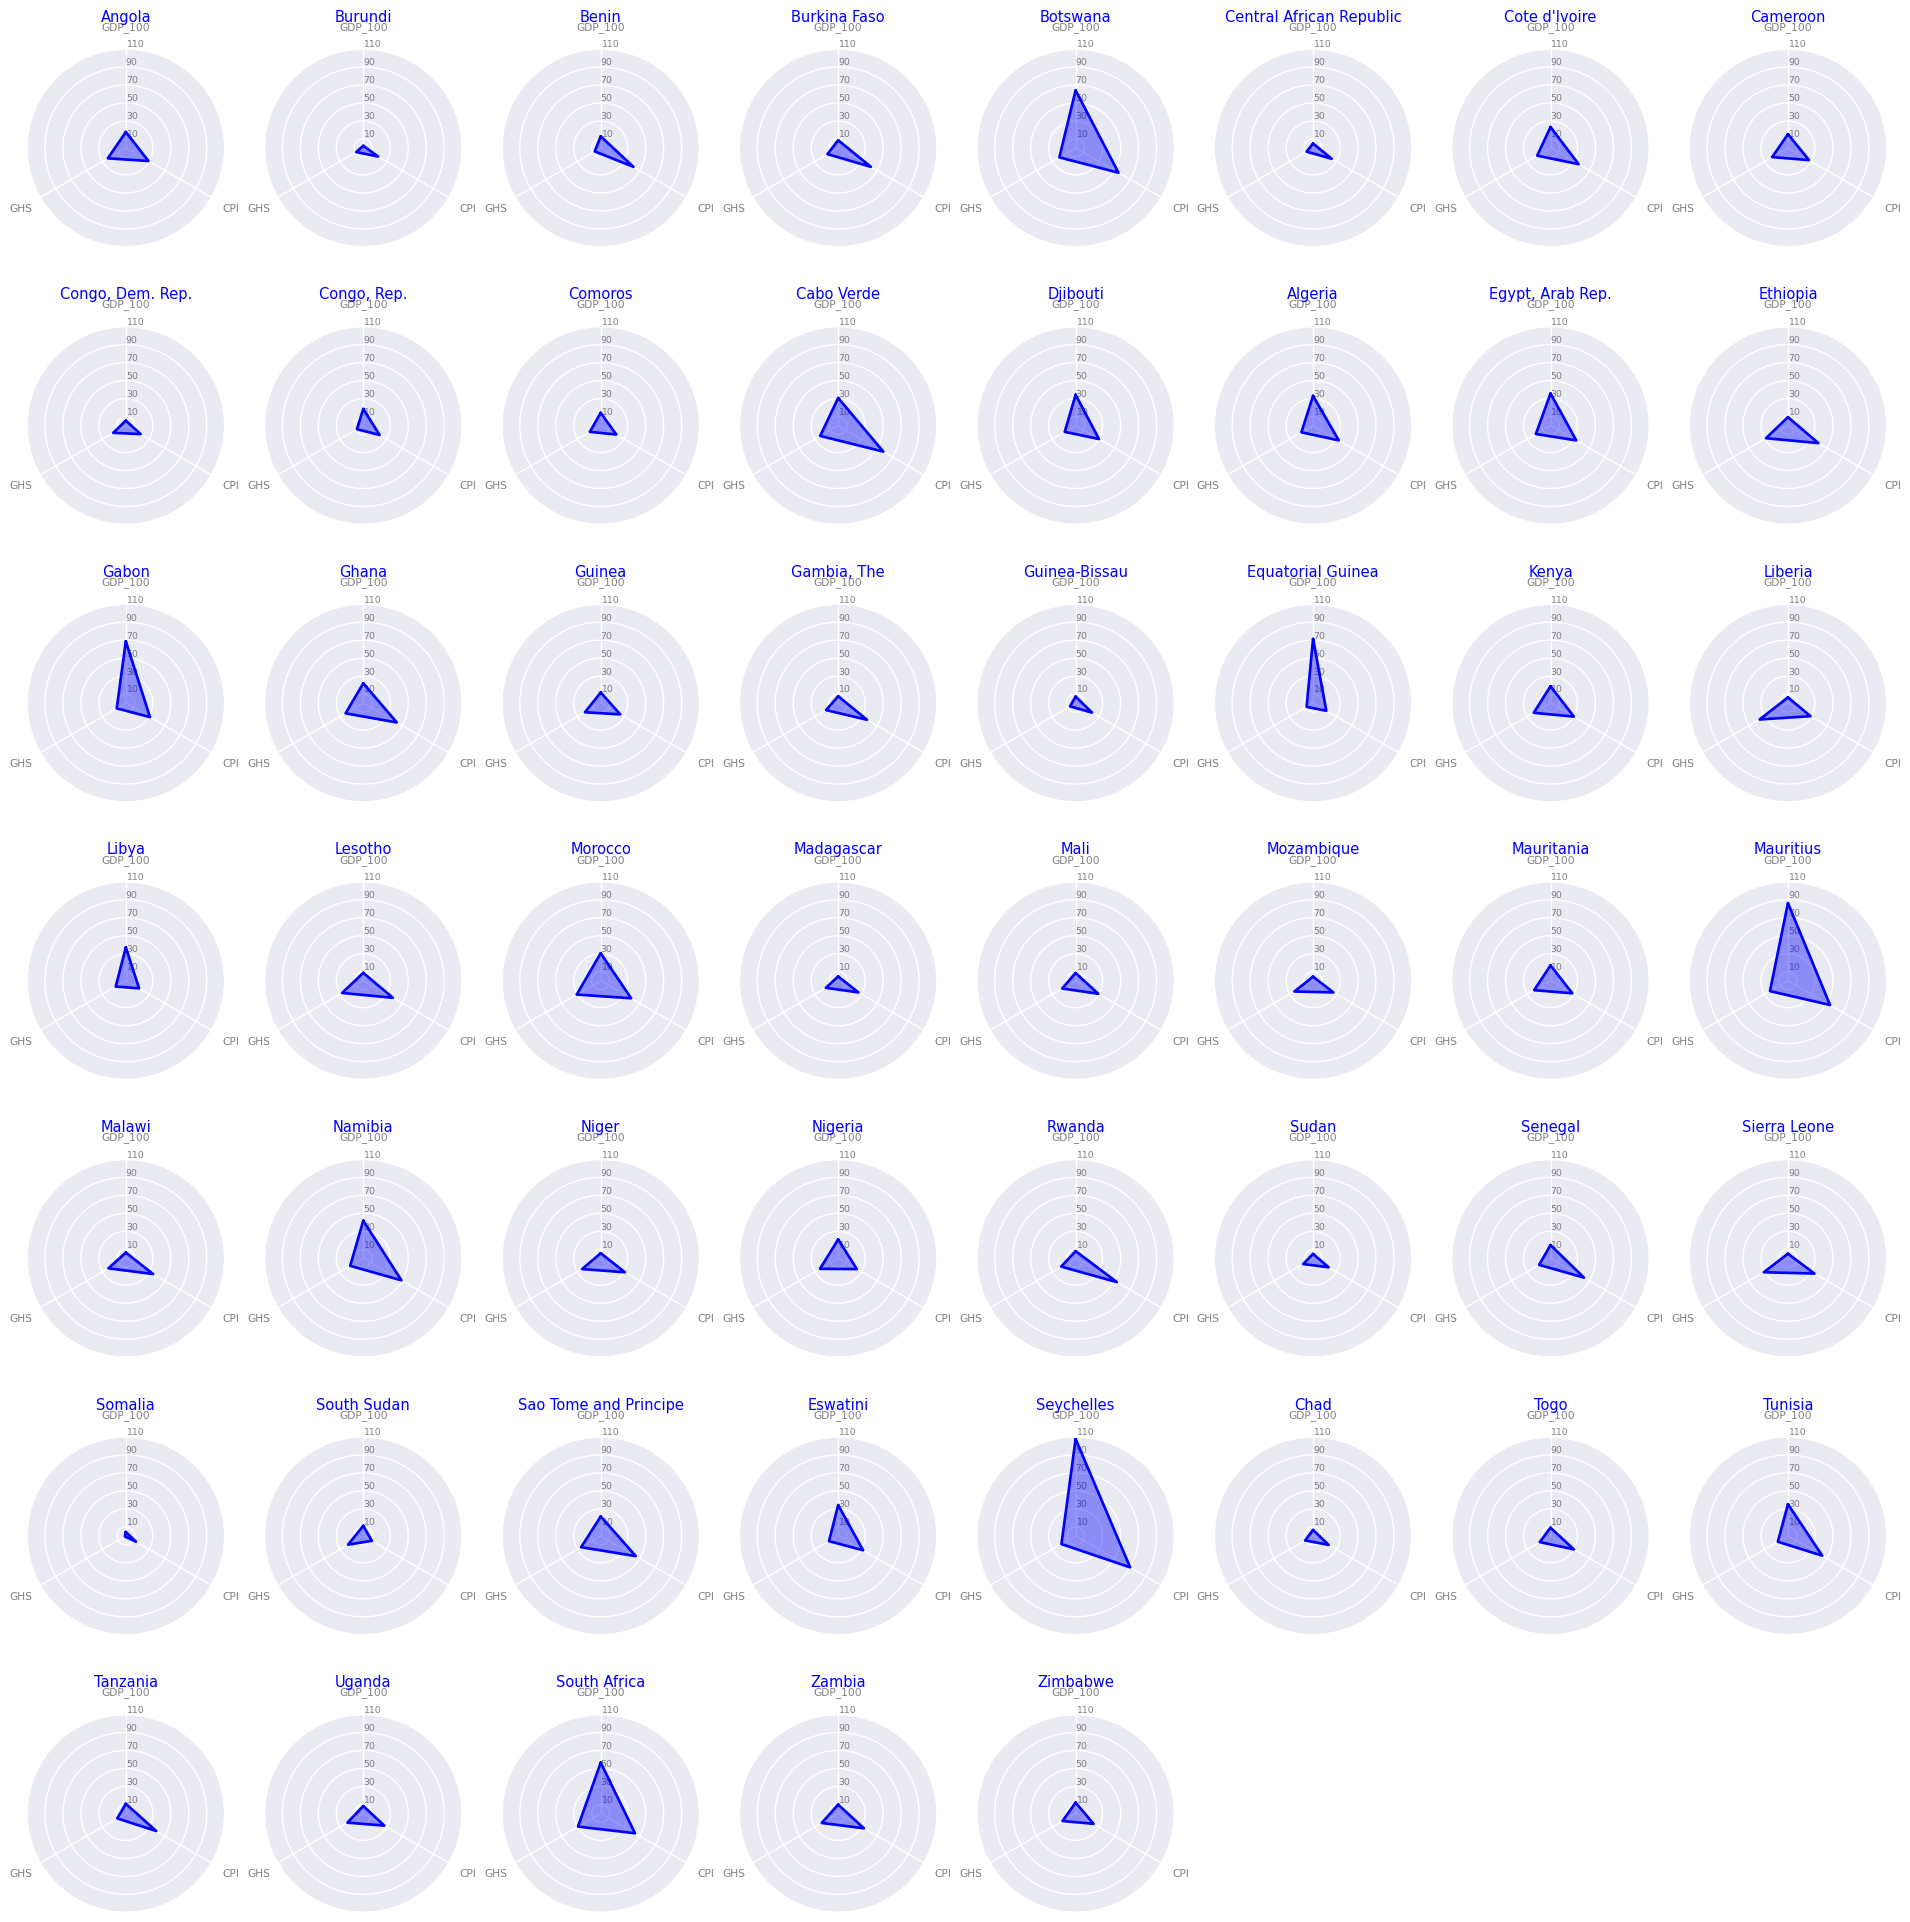

In [87]:
# code taken from https://python-graph-gallery.com/392-use-faceting-for-radar-chart
from math import pi
df = toPlot
def make_spider( row, title, color):

    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(8,8,row+1, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    ranges = np.arange(10, 120, 20)
    labels = [str(i) for i in ranges]
    plt.yticks(ranges, labels, color="grey", size=7)
    plt.ylim(0,110)

    # Ind1
    values=df.loc[row].drop('Country Name').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=11, color=color, y=1.1)

    
# ------- PART 2: Apply the function to all individuals
# initialize the figure
my_dpi=96
plt.figure(figsize=(25,30), dpi=96)
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df.index))
 
# Loop to plot
for row in range(0, len(df.index)):
    make_spider( row=row, title=df['Country Name'][row], color="blue")



# Clustering

In [88]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

(array([ 1.,  5.,  5.,  9., 10.,  9.,  8.,  3.,  2.,  1.]),
 array([ 1.3 ,  4.81,  8.32, 11.83, 15.34, 18.85, 22.36, 25.87, 29.38,
        32.89, 36.4 ]),
 <a list of 10 Patch objects>)

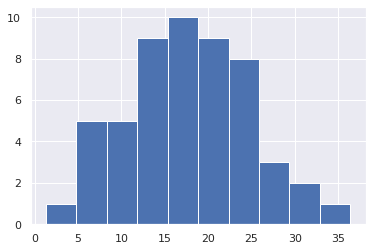

In [89]:
plt.hist(indecies['GHS'])


(array([ 2.,  9.,  9., 13.,  7.,  7.,  1.,  4.,  0.,  1.]),
 array([11. , 16.9, 22.8, 28.7, 34.6, 40.5, 46.4, 52.3, 58.2, 64.1, 70. ]),
 <a list of 10 Patch objects>)

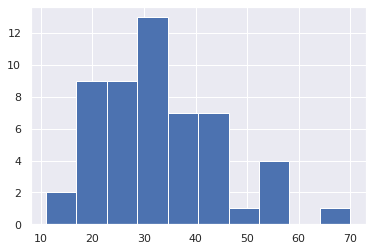

In [90]:
plt.hist(indecies['CPI'])

(array([27., 11.,  3.,  6.,  0.,  2.,  2.,  1.,  0.,  1.]),
 array([  2.38990726,  12.91533696,  23.44076665,  33.96619635,
         44.49162604,  55.01705574,  65.54248544,  76.06791513,
         86.59334483,  97.11877453, 107.64420422]),
 <a list of 10 Patch objects>)

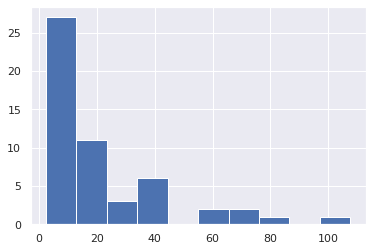

In [91]:
 plt.hist(indecies['GDP_100'])

In [92]:
num_data = indecies.iloc[:,3:6]
num_data.head()

,CPI,GHS,GDP_100
0,29,23.1,17.761669
1,19,9.1,2.389907
2,42,7.7,12.910410
3,42,13.7,8.579327
4,55,20.9,64.048999


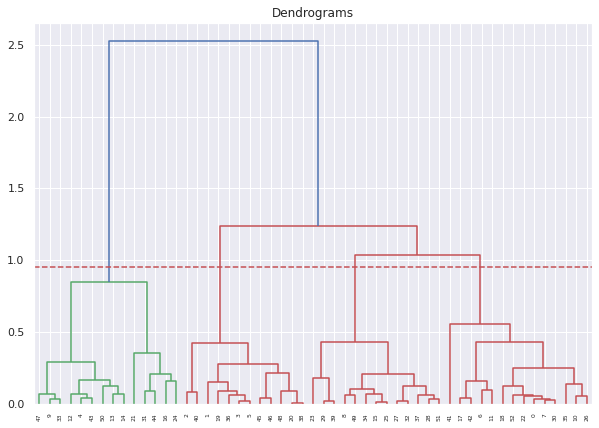

In [93]:
from sklearn.preprocessing import normalize
data_scaled = normalize(num_data)
data_scaled = pd.DataFrame(data_scaled, columns=num_data.columns)

import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))
plt.axhline(y=0.95, color='r', linestyle='--')

In [94]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
clusters = cluster.fit_predict(data_scaled)

indecies_copy = indecies.copy()
indecies_copy['Clusters'] = clusters
print(indecies_copy.groupby('Clusters').size())
print(indecies_copy.loc[indecies_copy['Clusters'] == 0].mean())
print(indecies_copy.loc[indecies_copy['Clusters'] == 1].mean())
print(indecies_copy.loc[indecies_copy['Clusters'] == 2].mean())
print(indecies_copy.loc[indecies_copy['Clusters'] == 3].mean())
indecies_copy


Clusters
0    14
1    14
2    12
3    13
dtype: int64
GDP         5175.008041
CPI           37.857143
GHS           15.857143
GDP_100       51.750080
Clusters       0.000000
dtype: float64
GDP         1910.848538
CPI           31.285714
GHS           21.342857
GDP_100       19.108485
Clusters       1.000000
dtype: float64
GDP         811.659561
CPI          31.916667
GHS          10.908333
GDP_100       8.116596
Clusters      2.000000
dtype: float64
GDP         675.270417
CPI          29.692308
GHS          22.823077
GDP_100       6.752704
Clusters      3.000000
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None'

,Country Name,Country Code,GDP,CPI,GHS,GDP_100,Clusters
0,Angola,AGO,1776.166868,29,23.1,17.761669,1
1,Burundi,BDI,238.990726,19,9.1,2.389907,2
2,Benin,BEN,1291.040972,42,7.7,12.910410,2
3,Burkina Faso,BFA,857.932730,42,13.7,8.579327,2
4,Botswana,BWA,6404.899932,55,20.9,64.048999,0
5,Central African Republic,CAF,492.795871,24,8.3,4.927959,2
6,Cote d'Ivoire,CIV,2325.723705,36,17.1,23.257237,1
7,Cameroon,CMR,1537.130218,27,20.3,15.371302,1
8,"Congo, Dem. Rep.",COD,543.950393,19,16.2,5.439504,3
9,"Congo, Rep.",COG,1846.131297,21,8.2,18.461313,0


In [95]:
print(indecies_copy.loc[indecies_copy['Clusters'] == 0]['Country Name'])
print(indecies_copy.loc[indecies_copy['Clusters'] == 1]['Country Name'])
print(indecies_copy.loc[indecies_copy['Clusters'] == 2]['Country Name'])
print(indecies_copy.loc[indecies_copy['Clusters'] == 3]['Country Name'])

4              Botswana
9           Congo, Rep.
12             Djibouti
13              Algeria
14     Egypt, Arab Rep.
16                Gabon
21    Equatorial Guinea
24                Libya
31            Mauritius
33              Namibia
43             Eswatini
44           Seychelles
47              Tunisia
50         South Africa
Name: Country Name, dtype: object
0                    Angola
6             Cote d'Ivoire
7                  Cameroon
10                  Comoros
11               Cabo Verde
17                    Ghana
18                   Guinea
22                    Kenya
26                  Morocco
30               Mauritania
35                  Nigeria
41              South Sudan
42    Sao Tome and Principe
52                 Zimbabwe
Name: Country Name, dtype: object
1                      Burundi
2                        Benin
3                 Burkina Faso
5     Central African Republic
19                 Gambia, The
20               Guinea-Bissau
36                

# COVID Trends Within Clusters

In [96]:
test = africa_vax[["iso_code", "date", "daily_vaccinations"]].dropna()
table = pd.pivot_table(test, values='daily_vaccinations', index=['iso_code'], columns=['date'], aggfunc=np.sum)

## Visualizing Clusters

In [97]:
indecies_copy["cluster"] = [str(i) for i in indecies_copy.Clusters]
fig = px.scatter_3d(indecies_copy, x='GDP', y='CPI', z='GHS',
                    color='cluster', hover_name="Country Name")
fig.show()
#fig.write_html("clusters.html")

In [ ]:
fig_map = go.Figure(px.choropleth(indecies_copy,
                                locations='Country Code', color="cluster",
                                hover_name='Country Name', 
                                hover_data = ["GDP", "GHS", "CPI"]))
fig_map.update_layout(geo_scope="africa")

## Linear Extrapolation

In [98]:
#create cumulative sum in order to get total vaccinations
table_cumsum = table.cumsum(axis = 1)

#lots of NAs, filter among these dates to minimize missing data
#2021-04-20 to 2022-03-19
table_sel = table_cumsum.iloc[:,101:435]

#fill in rest of missing data with linear interpolation
table_sel = table_sel.interpolate(method='linear', axis=1, limit_direction='both')

#divide by 2 in order to get a proxy for vaccinations
table_sel = table_sel / 2
table_sel

date,2021-04-20,2021-04-21,2021-04-22,2021-04-23,2021-04-24,2021-04-25,2021-04-26,2021-04-27,2021-04-28,2021-04-29,...,2022-03-10,2022-03-11,2022-03-12,2022-03-13,2022-03-14,2022-03-15,2022-03-16,2022-03-17,2022-03-18,2022-03-19
iso_code,,,,,,,,,,,,,,,,,,,,,
AGO,180043.5,188915.0,197535.0,205903.0,213571.5,220541.0,226811.0,232633.5,238008.5,242935.5,...,8410391.0,8430531.5,8451357.0,8472867.5,8495063.0,8517943.5,8540824.0,8563704.5,8585757.0,8606982.0
BDI,47.0,47.0,47.0,47.0,47.0,47.0,47.0,47.0,47.0,47.0,...,5289.0,5301.0,5313.0,5325.0,5337.0,5349.0,5361.0,5373.0,5385.0,5397.0
BEN,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,...,1511761.5,1517683.5,1522344.0,1525742.5,1527879.0,1528753.5,1529628.0,1530502.5,1531377.0,1532251.5
BFA,480.0,480.0,480.0,480.0,480.0,480.0,480.0,480.0,480.0,480.0,...,1168284.0,1169589.5,1171019.0,1172572.5,1174126.0,1175631.0,1177087.5,1178496.0,1179856.0,1181167.5
BWA,21293.0,22260.0,23119.0,23869.5,24532.0,25106.0,25591.5,26004.5,26344.5,26611.5,...,722107.0,722704.5,723241.0,723717.0,733695.5,753176.0,782159.0,820644.0,868631.0,926120.5
CAF,467.0,467.0,467.0,467.0,467.0,467.0,467.0,467.0,467.0,467.0,...,465906.5,470799.5,475218.5,479163.0,482633.0,485629.0,488150.5,490198.0,491771.0,493344.0
CIV,47108.5,48657.5,50215.5,51738.5,53430.5,55149.0,56678.5,58412.5,60364.0,62592.0,...,5024774.0,5038527.0,5050569.0,5059885.0,5066475.0,5070939.0,5076002.0,5081664.5,5087926.5,5094788.0
CMR,2517.0,2829.0,3141.0,3453.0,3765.0,4077.0,4389.0,4701.0,5013.0,5325.0,...,638932.0,642354.0,647471.5,654284.5,662793.5,672998.0,684898.0,696798.0,708698.0,720598.0
COD,243.0,364.5,486.0,607.5,729.0,850.5,983.0,1126.5,1281.0,1446.5,...,428615.5,429028.0,429440.5,429853.0,430265.5,430678.0,431090.5,431503.0,431915.5,432328.0


In [158]:
#merge clustes data frame with daily vaccinations
clusters = indecies_copy.iloc[:,[1,7]]
table_sel_clusters = pd.merge(clusters, table_sel, how='left', left_on=['Country Code'], right_on=['iso_code'])
table_sel_clusters.sort_values('Country Code').head()

,Country Code,cluster,2021-04-20 00:00:00,2021-04-21 00:00:00,2021-04-22 00:00:00,2021-04-23 00:00:00,2021-04-24 00:00:00,2021-04-25 00:00:00,2021-04-26 00:00:00,2021-04-27 00:00:00,...,2022-03-10 00:00:00,2022-03-11 00:00:00,2022-03-12 00:00:00,2022-03-13 00:00:00,2022-03-14 00:00:00,2022-03-15 00:00:00,2022-03-16 00:00:00,2022-03-17 00:00:00,2022-03-18 00:00:00,2022-03-19 00:00:00
0,AGO,1,180043.5,188915.0,197535.0,205903.0,213571.5,220541.0,226811.0,232633.5,...,8410391.0,8430531.5,8451357.0,8472867.5,8495063.0,8517943.5,8540824.0,8563704.5,8585757.0,8606982.0
1,BDI,2,47.0,47.0,47.0,47.0,47.0,47.0,47.0,47.0,...,5289.0,5301.0,5313.0,5325.0,5337.0,5349.0,5361.0,5373.0,5385.0,5397.0
2,BEN,2,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,...,1511761.5,1517683.5,1522344.0,1525742.5,1527879.0,1528753.5,1529628.0,1530502.5,1531377.0,1532251.5
3,BFA,2,480.0,480.0,480.0,480.0,480.0,480.0,480.0,480.0,...,1168284.0,1169589.5,1171019.0,1172572.5,1174126.0,1175631.0,1177087.5,1178496.0,1179856.0,1181167.5
4,BWA,0,21293.0,22260.0,23119.0,23869.5,24532.0,25106.0,25591.5,26004.5,...,722107.0,722704.5,723241.0,723717.0,733695.5,753176.0,782159.0,820644.0,868631.0,926120.5


In [159]:
#merge above dataframe with population
country2022pop = pd.read_csv('https://raw.githubusercontent.com/mchxo/africa_vaccination_forecast/main/AfricaCountryPopulations2022.csv')
country2022pop['POP_2022'] = pd.to_numeric(country2022pop['POP_2022'].str.replace(',', ''))

table_sel_clusters = pd.merge(country2022pop, table_sel_clusters, how='left', left_on=['Country'], right_on=['Country Code'])
table_sel_clusters.head()


,Country,POP_2022,Country Code,cluster,2021-04-20 00:00:00,2021-04-21 00:00:00,2021-04-22 00:00:00,2021-04-23 00:00:00,2021-04-24 00:00:00,2021-04-25 00:00:00,...,2022-03-10 00:00:00,2022-03-11 00:00:00,2022-03-12 00:00:00,2022-03-13 00:00:00,2022-03-14 00:00:00,2022-03-15 00:00:00,2022-03-16 00:00:00,2022-03-17 00:00:00,2022-03-18 00:00:00,2022-03-19 00:00:00
0,AGO,35027343,AGO,1,180043.5,188915.0,197535.0,205903.0,213571.5,220541.0,...,8410391.0,8430531.5,8451357.0,8472867.5,8495063.0,8517943.5,8540824.0,8563704.5,8585757.0,8606982.0
1,BDI,12624840,BDI,2,47.0,47.0,47.0,47.0,47.0,47.0,...,5289.0,5301.0,5313.0,5325.0,5337.0,5349.0,5361.0,5373.0,5385.0,5397.0
2,BEN,12784726,BEN,2,125.0,125.0,125.0,125.0,125.0,125.0,...,1511761.5,1517683.5,1522344.0,1525742.5,1527879.0,1528753.5,1529628.0,1530502.5,1531377.0,1532251.5
3,BFA,22102838,BFA,2,480.0,480.0,480.0,480.0,480.0,480.0,...,1168284.0,1169589.5,1171019.0,1172572.5,1174126.0,1175631.0,1177087.5,1178496.0,1179856.0,1181167.5
4,BWA,2441162,BWA,0,21293.0,22260.0,23119.0,23869.5,24532.0,25106.0,...,722107.0,722704.5,723241.0,723717.0,733695.5,753176.0,782159.0,820644.0,868631.0,926120.5


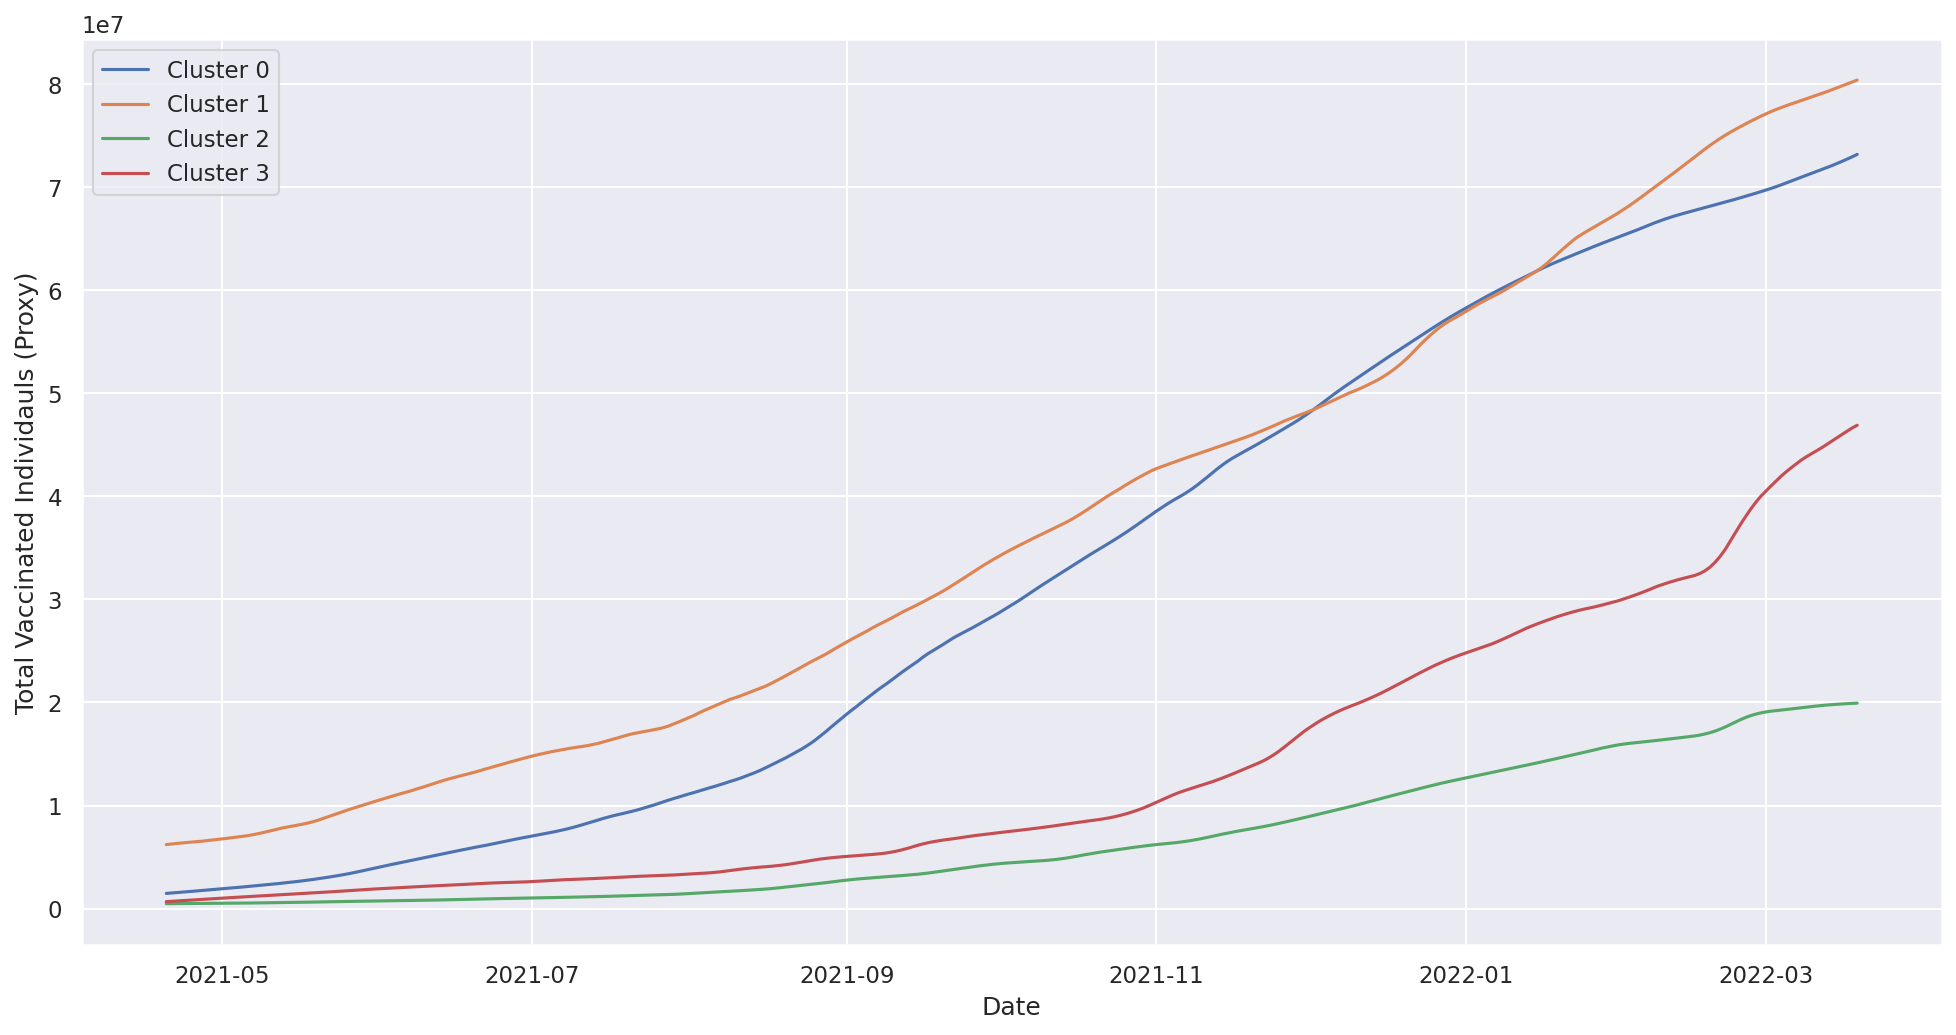

In [160]:
import matplotlib.pyplot as plt

cluster_0 = table_sel_clusters.loc[table_sel_clusters['cluster'] == '0']
cluster_1 = table_sel_clusters.loc[table_sel_clusters['cluster'] == '1']
cluster_2 = table_sel_clusters.loc[table_sel_clusters['cluster'] == '2']
cluster_3 = table_sel_clusters.loc[table_sel_clusters['cluster'] == '3']

test0 = pd.DataFrame(data = cluster_0.sum(axis=0))[4:]
test1 = pd.DataFrame(data = cluster_1.sum(axis=0))[4:]
test2 = pd.DataFrame(data = cluster_2.sum(axis=0))[4:]
test3 = pd.DataFrame(data = cluster_3.sum(axis=0))[4:]

plt.figure(figsize=(16, 8), dpi=150)
plt.plot(test0, label = 'Cluster 0')
plt.plot(test1, label = 'Cluster 1')
plt.plot(test2, label = 'Cluster 2')
plt.plot(test3, label = 'Cluster 3')
plt.xlabel('Date')
plt.ylabel('Total Vaccinated Individauls (Proxy)')
plt.legend()

In [175]:
#Cluster 0 current total vaccination rate
cluster_0_curr_vac = cluster_0.iloc[:,337].sum() / cluster_0['POP_2022'].sum()
print('Cluster 0 Current Vaccination Rate', round(cluster_0_curr_vac*100, 2), '%')

#Cluster 0 Eblow at 2021-08-15
cluster_0.iloc[:,[119,335]].sum(axis=0)

#compute slope 
#total time between 2021-08-15 and 2022-03-19 is 216 days
diff_vaccinated = 73193373 - 13421351
cluster_0_slope = diff_vaccinated / 216
print('Cluster 0 Slope', round(cluster_0_slope, 0), 'additional vaccinated people per day')

#compute estimate, 287 days later
cluster_0_newly_vaccinated = cluster_0_slope * 287
cluster_0_pred_vac = (cluster_0.iloc[:,337].sum() + cluster_0_newly_vaccinated) / cluster_0['POP_2022'].sum()
print('Cluster 0 Predicted Vaccination Rate', round(cluster_0_pred_vac*100, 2), '%')

Cluster 0 Current Vaccination Rate 29.32 %
Cluster 0 Slope 276722.0 additional vaccinated people per day
Cluster 0 Predicted Vaccination Rate 61.14 %


In [176]:
#Cluster 1 current total vaccination rate
cluster_1_curr_vac = cluster_1.iloc[:,337].sum() / cluster_1['POP_2022'].sum()
print('Cluster 1 Current Vaccination Rate', round(cluster_1_curr_vac*100, 2), '%')

#Cluster 1 Eblow at 2021-12-15
cluster_1.iloc[:,[241,335]].sum(axis=0)

#compute slope 
#total time between 2021-12-15 and 2022-03-19 is 94 days
diff_vaccinated = 80409106.0 - 51418390.5
cluster_1_slope = diff_vaccinated / 94
print('Cluster 1 Slope', round(cluster_1_slope, 0), 'additional vaccinated people per day')


#compute estimate, 287 days later
cluster_1_newly_vaccinated = cluster_1_slope * 287
cluster_1_pred_vac = (cluster_1.iloc[:,337].sum() + cluster_1_newly_vaccinated) / cluster_1['POP_2022'].sum()
print('Cluster 1 Predicted Vaccination Rate', round(cluster_1_pred_vac*100, 2), '%')

Cluster 1 Current Vaccination Rate 16.71 %
Cluster 1 Slope 308412.0 additional vaccinated people per day
Cluster 1 Predicted Vaccination Rate 35.1 %


In [177]:
#Cluster 2 current total vaccination rate
cluster_2_curr_vac = cluster_2.iloc[:,337].sum() / cluster_2['POP_2022'].sum()
print('Cluster 2 Current Vaccination Rate', round(cluster_2_curr_vac*100, 2), '%')

#Cluster 2 Eblow at 2021-11-01
cluster_2.iloc[:,[197,335]].sum(axis=0)

#compute slope 
#total time between 2021-11-01 and 2022-03-19 is 138 days
diff_vaccinated = 19939050.5 - 6212640.0
cluster_2_slope = diff_vaccinated / 138
print('Cluster 2 Slope', round(cluster_2_slope, 0), 'additional vaccinated people per day')

#compute estimate, 287 days later
cluster_2_newly_vaccinated = cluster_2_slope * 287
cluster_2_pred_vac = (cluster_2.iloc[:,337].sum() + cluster_2_newly_vaccinated) / cluster_2['POP_2022'].sum()
print('Cluster 2 Predicted Vaccination Rate', round(cluster_2_pred_vac*100, 2), '%')


Cluster 2 Current Vaccination Rate 10.24 %
Cluster 2 Slope 99467.0 additional vaccinated people per day
Cluster 2 Predicted Vaccination Rate 24.91 %


In [179]:
#Cluster 3 current total vaccination rate
cluster_3_curr_vac = cluster_3.iloc[:,337].sum() / cluster_3['POP_2022'].sum()
print('Cluster 3 Current Vaccination Rate', round(cluster_3_curr_vac*100, 2), '%')

#Cluster 3 Eblow at 2022-02-15
cluster_3.iloc[:,[303,335]].sum(axis=0)

#compute slope 
#total time between 2022-02-15 and 2022-03-19 is 32 days
diff_vaccinated = 46906626.0 - 32330137.5
cluster_3_slope = diff_vaccinated / 32
print('Cluster 3 Slope', round(cluster_3_slope, 0), 'additional vaccinated people per day')

#compute estimate, 287 days later
cluster_3_newly_vaccinated = cluster_3_slope * 287
cluster_3_pred_vac = (cluster_3.iloc[:,337].sum() + cluster_3_newly_vaccinated) / cluster_3['POP_2022'].sum()
print('Cluster 3 Predicted Vaccination Rate', round(cluster_3_pred_vac*100, 2), '%')

#compute 80% CI 



Cluster 3 Current Vaccination Rate 9.86 %
Cluster 3 Slope 455515.0 additional vaccinated people per day
Cluster 3 Predicted Vaccination Rate 37.34 %


In [191]:
#Overall Mean
total_vacc = (cluster_0.iloc[:,337].sum() + cluster_0_newly_vaccinated) + (cluster_1 .iloc[:,337].sum() + cluster_1_newly_vaccinated) + (cluster_2.iloc[:,337].sum() + cluster_2_newly_vaccinated) + (cluster_3.iloc[:,337].sum() + cluster_3_newly_vaccinated)
total_pop = table_sel_clusters['POP_2022'].sum()

print('Overall Predicted Vaccination Rate for End of 2022', round(100*total_vacc / total_pop, 2), '%')

#Overall 80% CI
##Lower
lower_total = (cluster_0['POP_2022'].sum() * 0.55) + (cluster_1['POP_2022'].sum() * 0.30) + (cluster_2['POP_2022'].sum() * 0.15) + (cluster_3['POP_2022'].sum() * 0.20)
print('Lower 80% Predicted Vaccination Rate for End of 2022', round(100*lower_total / total_pop, 2), '%')

higher_total = (cluster_0['POP_2022'].sum() * 0.75) + (cluster_1['POP_2022'].sum() * 0.45) + (cluster_2['POP_2022'].sum() * 0.32) + (cluster_3['POP_2022'].sum() * 0.50)
print('Upper 80% Predicted Vaccination Rate for End of 2022', round(100*higher_total / total_pop, 2), '%')


Overall Predicted Vaccination Rate for End of 2022 39.08 %
Lower 80% Predicted Vaccination Rate for End of 2022 28.97 %
Upper 80% Predicted Vaccination Rate for End of 2022 50.24 %
